In [1]:
import os

import numpy as np
import pandas as pd
import datetime

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import tensorflow.keras as tfk
import tensorflow.keras.backend as K
import tensorflow as tf
from kerastuner.tuners import RandomSearch
from kerastuner import HyperModel

In [2]:
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


In [3]:
INPUT_LEN = 16
FORECAST_HORIZON = 16
ROLLING_WINDOW_SKIP = 1
TS_LEN_LIM = 300         # limit length of each timeseries
TS_LIM = 100

DIR = "datasets/clean/"

EPS = 1e-9

# control tightness of bounds:
MIS_ALPHA = 0.1   # tightness of upper bound (lower the better)
MIS_BETA  = 0.1   # tightness of lower bound

# control loss importance
LOSS_ALPHA = 1 # 1/5 for RMSE
LOSS_BETA  = 1
LOSS_GAMMA = 1

## Load Dataset

In [4]:
df_sources = pd.read_csv('dataset_sources.csv')
df_train = pd.read_csv('dataset_sources_train.csv')
df_test  = pd.read_csv('dataset_sources_test.csv')

In [5]:
print(len(df_train))
print(len(df_test))

4775
1123


In [6]:
freq_one_hot = {'hourly'   : [1]  +[0]*5,
                'dihourly' : [0]  +[1]  +[0]*4,
                'daily'    : [0]*2+[1]  +[0]*3,
                'didaily'  : [0]*3+[1]  +[0]*2,
                'monthly'  : [0]*4+[1]  +[0]*1,
                'yearly'   : [0]*5+[1]}

## Load Encoder

In [7]:
autoencoder = tfk.models.load_model('.model_files/autoencoder_train.h5')
encoder, _ = autoencoder.layers
encoder.trainable=False

## Transform Train Set

In [8]:
%%time
X, y         = [], []
#X_min, X_max, X_trend, X_seaso = [], [], [], []
data_origins = []
data_ts_ids  = []
data_freqs   = []

for origin in np.unique(df_train['origin']):
    i = np.where(df_train['origin'] == origin)
    
    df_sample = df_train.iloc[i].sample(frac=1).iloc[:TS_LIM]
    for id, row in df_sample.iterrows():
        
        origin = row['origin']
        freq   = row['freq']
        source = row['source']
        
        source = source.split('/')
        source[1] = 'clean'
        source = '/'.join(source)
        
        df_data = pd.read_csv(source)
        df_data['resid_scaled'] = np.clip(df_data['resid_scaled'], 0, 1)
        
        prev_vals = []
        
        for START_IN in range(max(0, len(df_data)-FORECAST_HORIZON-TS_LEN_LIM),
                              len(df_data)-FORECAST_HORIZON, ROLLING_WINDOW_SKIP):
            END_IN  = START_IN + INPUT_LEN
            END_OUT = END_IN + FORECAST_HORIZON
            if END_OUT > len(df_data):
                break
            
            prev_val = np.array(df_data['resid_scaled'][START_IN:END_IN]).reshape(INPUT_LEN, 1)
            prev_vals.append(prev_val)
        
        if len(prev_vals) == 0:
            continue
            
        prev_vals = np.array(prev_vals)         #(285, 16, 1)
        prev_embs = encoder.predict(prev_vals)  #(285, 4)
        
        iter_id = 0
        
        for START_IN in range(max(0, len(df_data)-FORECAST_HORIZON-TS_LEN_LIM),
                              len(df_data)-FORECAST_HORIZON, ROLLING_WINDOW_SKIP):
            END_IN  = START_IN + INPUT_LEN
            END_OUT = END_IN + FORECAST_HORIZON
            if END_OUT > len(df_data):
                break
            
            prev_ave = prev_embs[:iter_id+1].mean(axis=0)
            prev_emb = prev_embs[iter_id]
            
            iter_id += 1
            
            #freq_emb = np.array(freq_one_hot[freq]).reshape(6)
            
            #x = np.concatenate((prev_ave, prev_emb, freq_emb), axis=-1)
            x = np.concatenate((prev_ave, prev_emb), axis=-1)
            
            X.append(x)
            #X_min.append(df_data['resid_min'][START_IN:END_IN])
            #X_max.append(df_data['resid_max'][START_IN:END_IN])
            #X_trend.append(df_data['trend'][START_IN:END_IN])
            #X_seaso.append(df_data['seasonal'][START_IN:END_IN])
            y.append(df_data['resid_scaled'][END_IN:END_OUT])
            data_origins.append(origin)
            data_ts_ids.append(id)
            data_freqs.append(freq)

Wall time: 13.5 s


In [9]:
%%time
X               = np.array(X).reshape(-1, 8)
#X_min           = np.array(X_min).reshape(-1, INPUT_LEN, 1)
#X_max           = np.array(X_max).reshape(-1, INPUT_LEN, 1)
#X_trend         = np.array(X_trend).reshape(-1, INPUT_LEN, 1)
#X_seaso         = np.array(X_seaso).reshape(-1, INPUT_LEN, 1)
y               = np.array(y).reshape(-1, FORECAST_HORIZON, 1)
data_origins    = np.array(data_origins)
data_ts_ids     = np.array(data_ts_ids)
data_freqs      = np.array(data_freqs)

Wall time: 507 ms


In [10]:
print(X.shape)
print(y.shape)

(20422, 8)
(20422, 16, 1)


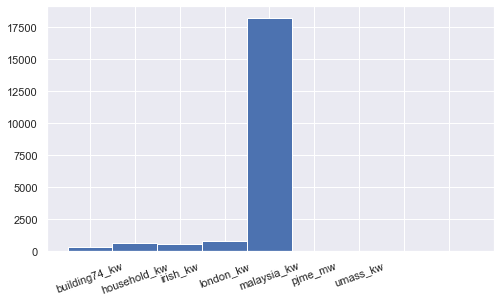

In [11]:
plt.figure(figsize=(8, 4.5))
plt.hist(data_origins, bins=np.arange(10)-0.5)
plt.xticks(range(10), np.unique(df_sources['origin']) + [''], rotation=20)
plt.show()

## Build Seq2Seq Model

In [12]:
def mean_interval_score(lower_bound, upper_bound, y_true):
    return K.mean(
        upper_bound - lower_bound
        + (2/MIS_ALPHA)*(y_true - upper_bound)*K.cast(upper_bound < y_true, 'float32')
        + (2/MIS_BETA)*(lower_bound - y_true)*K.cast(y_true < lower_bound, 'float32'),
        axis=[-1]
    )

def clipped_rmse(y_true, y_pred):
    y_true = K.clip(y_true, K.epsilon(), 1)
    y_pred = K.clip(y_pred, K.epsilon(), 1)
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=[-1]))

def smooth_smape(y_true, y_pred):
    epsilon = 0.1
    summ = K.maximum(K.abs(y_true) + K.abs(y_pred) + epsilon, 0.5 + epsilon)
    smape = K.abs(y_true - y_pred) / summ * 2.0
    return K.mean(smape, axis=[-1])

In [13]:
class MyHyperModel(HyperModel):
    def __init__(self, input_dim, forecast_horizon):
        self.input_dim = input_dim
        self.forecast_horizon = forecast_horizon
    
    def build(self, hp):
        forecaster_input    = tfk.layers.Input((self.input_dim,),
                                               name='forecaster_input')
        forecaster_repeater = tfk.layers.RepeatVector(self.forecast_horizon,
                                                      name='forecaster_repeat_vector')(forecaster_input)

        forecaster_lstm_1   = tfk.layers.LSTM(hp.Choice('lstm_1_hidden_units',
                                                        [4**f*self.input_dim for f in range(4)]),
                                              activation='relu',
                                              return_sequences=True,
                                              name='forecaster_lstm_1')(forecaster_repeater)
        forecaster_lstm_2   = tfk.layers.LSTM(hp.Choice('lstm_1_hidden_units',
                                                        [4**f*self.input_dim for f in range(4)]),
                                              activation='relu',
                                              return_sequences=True,
                                              name='forecaster_lstm_2')(forecaster_lstm_1)
        
        
        if hp.Boolean('separate_heads', default=True):
            forecaster_dense_1     = tfk.layers.TimeDistributed(
                tfk.layers.Dense(hp.Choice('dense_1_units',
                                            [4**f*self.input_dim for f in range(4)]),
                                 activation='relu'), name='forecaster_dense_1')(forecaster_lstm_2)
            forecaster_lower_bound = tfk.layers.TimeDistributed(
                tfk.layers.Dense(1, activation='sigmoid'), name='forecaster_lower_bound')(forecaster_dense_1)
            forecaster_upper_bound = tfk.layers.TimeDistributed(
                tfk.layers.Dense(1, activation='sigmoid'), name='forecaster_upper_bound')(forecaster_dense_1)

            forecaster_dense_2     = tfk.layers.TimeDistributed(
                tfk.layers.Dense(hp.Choice('dense_2_units',
                                            [4**f*self.input_dim for f in range(4)]),
                                 activation='relu'), name='forecaster_dense_2')(forecaster_lstm_2)
            forecaster_mean_pred   = tfk.layers.TimeDistributed(
                tfk.layers.Dense(1, activation='sigmoid'), name='forecaster_mean_pred')(forecaster_dense_2)
        else:
            forecaster_dense_1     = tfk.layers.TimeDistributed(
                tfk.layers.Dense(hp.Choice('dense_1_units',
                                            [4**f*self.input_dim for f in range(4)]),
                                 activation='relu'), name='forecaster_dense_1')(forecaster_lstm_2)
            forecaster_lower_bound = tfk.layers.TimeDistributed(
                tfk.layers.Dense(1, activation='sigmoid'), name='forecaster_lower_bound')(forecaster_dense_1)
            
            forecaster_dense_2     = tfk.layers.TimeDistributed(
                tfk.layers.Dense(hp.Choice('dense_2_units',
                                            [4**f*self.input_dim for f in range(4)]),
                                 activation='relu'), name='forecaster_dense_2')(forecaster_lstm_2)
            forecaster_upper_bound = tfk.layers.TimeDistributed(
                tfk.layers.Dense(1, activation='sigmoid'), name='forecaster_upper_bound')(forecaster_dense_2)

            forecaster_dense_3     = tfk.layers.TimeDistributed(
                tfk.layers.Dense(hp.Choice('dense_1_units',
                                            [4**f*self.input_dim for f in range(4)]),
                                 activation='relu'), name='forecaster_dense_3')(forecaster_lstm_2)
            forecaster_mean_pred   = tfk.layers.TimeDistributed(
                tfk.layers.Dense(1, activation='sigmoid'), name='forecaster_mean_pred')(forecaster_dense_3)
        
        forecaster = tfk.Model(inputs=forecaster_input,
                               outputs=[forecaster_lower_bound,
                                        forecaster_mean_pred,
                                        forecaster_upper_bound], name="forecaster")
        
        input_features = tfk.layers.Input((self.input_dim,),          name='input_features')
        input_target   = tfk.layers.Input((self.forecast_horizon, 1), name='input_target')

        y_pred_lower_bound, y_pred_mean, y_pred_upper_bound = forecaster(input_features)

        mis_loss = tfk.layers.Lambda(
            lambda x : mean_interval_score(x[0][0], x[0][1], x[1]), name="mis_loss"
        )([[y_pred_lower_bound, y_pred_upper_bound], input_target])

        rmse_loss = tfk.layers.Lambda(
            lambda x : clipped_rmse(x[0], x[1]), name="rmse_loss"
        )([y_pred_mean, input_target])

        smape_loss = tfk.layers.Lambda(
            lambda x : smooth_smape(x[0], x[1]), name="smape_loss"
        )([y_pred_mean, input_target])

        model = tfk.Model([input_features, input_target],
                          [mis_loss, rmse_loss],
                          name='final_model')

        model.add_loss(K.mean(LOSS_ALPHA * mis_loss))
        #model.add_loss(K.mean(LOSS_BETA * rmse_loss))
        model.add_loss(K.mean(LOSS_GAMMA * smape_loss))

        model.add_metric(LOSS_ALPHA*mis_loss,   name='mis',   aggregation='mean')
        model.add_metric(LOSS_BETA *rmse_loss,  name='rmse',  aggregation='mean')
        model.add_metric(LOSS_GAMMA*smape_loss, name='smape', aggregation='mean')

        model.compile(loss=[None]*2, 
                      optimizer=tfk.optimizers.Adam(hp.Choice('learning_rate',
                                                              [1e-2, 1e-3, 1e-4]), 
                                                    #clipvalue=0.5
                                                   ))
        return model

In [14]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    cooldown=3,
    min_lr=1e-5
)

early_stop = tfk.callbacks.EarlyStopping(
    monitor='val_smape',
    patience=15,
    restore_best_weights=True
)

checkpoint_dir = os.path.join('.model_files')
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
checkpoint = tfk.callbacks.ModelCheckpoint(
    filepath = checkpoint_dir + '/ckpt/',
    save_freq =2000,
    save_best_only=True
)

log_dir = os.path.join(".model_files\\logs\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
#log_dir = os.path.join("logs\\tuner_test")

print(log_dir)

if not os.path.exists(log_dir):
    os.makedirs(log_dir)
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=0,
    update_freq=100,
    profile_batch = 100000000
    #profile_batch = 2000
)

.model_files\logs\20200517-134750


In [15]:
hypermodel = MyHyperModel(input_dim=X.shape[1], forecast_horizon=FORECAST_HORIZON)

tuner = RandomSearch(
    hypermodel,
    objective='val_loss',
    max_trials=10,
    directory=log_dir,
    project_name='test')

tuner.search_space_summary()

## Train Model

In [16]:
tuner.search({"input_features" : X,
              "input_target" : y},
              epochs=1000, batch_size=256,
              validation_split=0.2,
              callbacks=[reduce_lr,
                         early_stop, 
                         #checkpoint, 
                         tensorboard_callback
                        ],
             verbose=0)

KeyboardInterrupt: 

In [17]:
model = tuner.get_best_models(num_models=1)[0]

In [18]:
forecaster = model.layers[1]

In [98]:
model.save('.model_files/lstm_forecaster_model_f30__a={}_b={}.h5'.format(MIS_ALPHA, MIS_BETA))
forecaster.save('.model_files/lstm_forecaster_component_f30__a={}_b={}.h5'.format(MIS_ALPHA, MIS_BETA))

In [ ]:
#model.save('.model_files/seq2seq_final_model_train__a={}_b={}.h5'.format(MIS_ALPHA, MIS_BETA))
#seq2seq.save('.model_files/seq2seq_component_train__a={}_b={}.h5'.format(MIS_ALPHA, MIS_BETA))
#decoder.save('.model_files/seq2seq_decoder_train__a={}_b={}.h5'.format(MIS_ALPHA, MIS_BETA))

In [ ]:
#seq2seq = tfk.models.load_model('.model_files/seq2seq_component_train__a={}_b={}.h5'.format(MIS_ALPHA, MIS_BETA))

In [ ]:
# tensorboard --logdir=./.model_files/logs/20200512-052112/train/ --bind_all --port 8080
# ngrok http 8080

## Test

In [19]:
df_test.head()

,Unnamed: 0,origin,freq,source
0,0,building74_kw,hourly,datasets/clean_nonseasonal/building74_kw/build...
1,1,irish_kw,monthly,datasets/clean_nonseasonal/irish_kw/irish__mon...
2,2,london_kw,monthly,datasets/clean_nonseasonal/london_kw/london000...
3,3,london_kw,monthly,datasets/clean_nonseasonal/london_kw/london000...
4,4,london_kw,monthly,datasets/clean_nonseasonal/london_kw/london000...


In [88]:
FORECAST_STEPS = 15

In [89]:
while True:
    dataset_id = int(np.random.rand() * len(df_test))
    
    source = df_test.iloc[dataset_id]['source']
    source = source.split('/')
    source[1] = 'clean'
    source = '/'.join(source)
    
    df_data = pd.read_csv(source)
    if len(df_data) > (FORECAST_STEPS + 1)*16:
        break

In [90]:
df_test.iloc[dataset_id]

Unnamed: 0                                                 1100
origin                                                 umass_kw
freq                                                      daily
source        datasets/clean_nonseasonal/umass_kw/apt73__dai...
Name: 1100, dtype: object

In [91]:
df_data.head()

,date,y,trend,seasonal,resid,resid_min,resid_max,resid_scaled
0,2014-11-10,59.732740,116.580773,1.049225,0.488334,0.108897,2.146914,0.186179
1,2014-11-11,178.006444,132.317832,0.995215,1.351763,0.108897,2.146914,0.609841
2,2014-11-12,107.754766,148.054891,0.972294,0.748542,0.108897,2.146914,0.313857
3,2014-11-13,189.166471,163.791950,0.958364,1.205094,0.108897,2.146914,0.537875
4,2014-11-14,188.525994,179.529009,0.960046,1.093816,0.108897,2.146914,0.483273


In [92]:
y_lower_bound = np.array([])
y_pred_mean   = np.array([])
y_upper_bound = np.array([])
y_true        = np.array([])

prev_embs = []

INPUT_DIM = 8

for i in range(FORECAST_STEPS):
    x = df_data['resid_scaled'][i*INPUT_LEN:(i+1)*INPUT_LEN].to_numpy().reshape(1, INPUT_LEN, 1)
    x = np.clip(x, 0, 1)
    prev_val = x
    prev_emb = encoder.predict(prev_val)
    prev_embs.append(prev_emb)
    
    #freq = df_test.iloc[i]['freq']
    #freq_emb = np.array(freq_one_hot[freq]).reshape(6)
    
    features = np.concatenate((prev_emb.flatten(), np.mean(prev_embs, axis=0).flatten())).reshape(1, INPUT_DIM)
    
    res = forecaster.predict(features)
    lower_bound, y_pred, upper_bound = res
    lower_bound = lower_bound.reshape(FORECAST_HORIZON)
    y_pred      = y_pred.reshape(FORECAST_HORIZON)
    upper_bound = upper_bound.reshape(FORECAST_HORIZON)
    
    y_lower_bound = np.concatenate([y_lower_bound, lower_bound])
    y_pred_mean   = np.concatenate([y_pred_mean, y_pred])
    y_upper_bound = np.concatenate([y_upper_bound, upper_bound])
    y_true        = np.concatenate([y_true, df_data['resid_scaled'][(i+1)*FORECAST_HORIZON:(i+2)*FORECAST_HORIZON].to_numpy()])

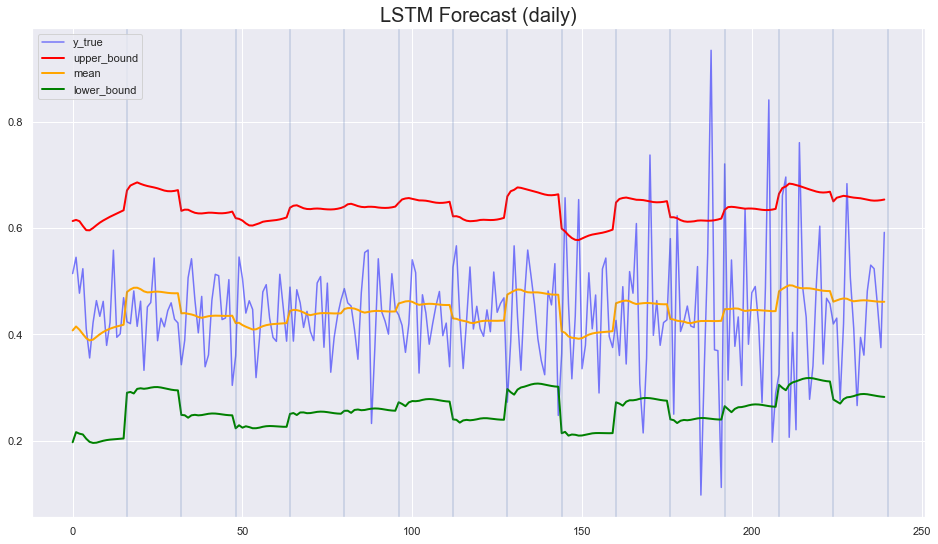

In [93]:
plt.figure(figsize=(16, 9))
plt.plot(y_true, alpha=0.5, c='blue', label='y_true')
plt.plot(y_upper_bound, linewidth=2, c='red', label='upper_bound')
plt.plot(y_pred_mean,   linewidth=2, c='orange', label='mean')
plt.plot(y_lower_bound, linewidth=2, c='green', label='lower_bound')
plt.title("LSTM Forecast ({})".format(df_test.iloc[dataset_id]['freq']), fontsize=20)
plt.savefig('lstm_forecast.png', 
            #transparent=True,
            bbox_inches='tight')
plt.legend()
for i in range(16, FORECAST_STEPS*16+1, 16):
    plt.axvline(x=i, alpha=0.25)
plt.show()

In [94]:
def deprocess(y):
    y = (y * ( df_data['resid_max'].iloc[FORECAST_HORIZON:FORECAST_HORIZON+FORECAST_STEPS*16] - 
               df_data['resid_min'].iloc[FORECAST_HORIZON:FORECAST_HORIZON+FORECAST_STEPS*16])
            +  df_data['resid_min'].iloc[FORECAST_HORIZON:FORECAST_HORIZON+FORECAST_STEPS*16])
    return (y *    df_data['trend'].iloc[FORECAST_HORIZON:FORECAST_HORIZON+FORECAST_STEPS*16] 
              * df_data['seasonal'].iloc[FORECAST_HORIZON:FORECAST_HORIZON+FORECAST_STEPS*16])

In [95]:
y_lower_bound = deprocess(y_lower_bound)
y_pred_mean   = deprocess(y_pred_mean  )
y_upper_bound = deprocess(y_upper_bound)
y_true        = deprocess(y_true       )

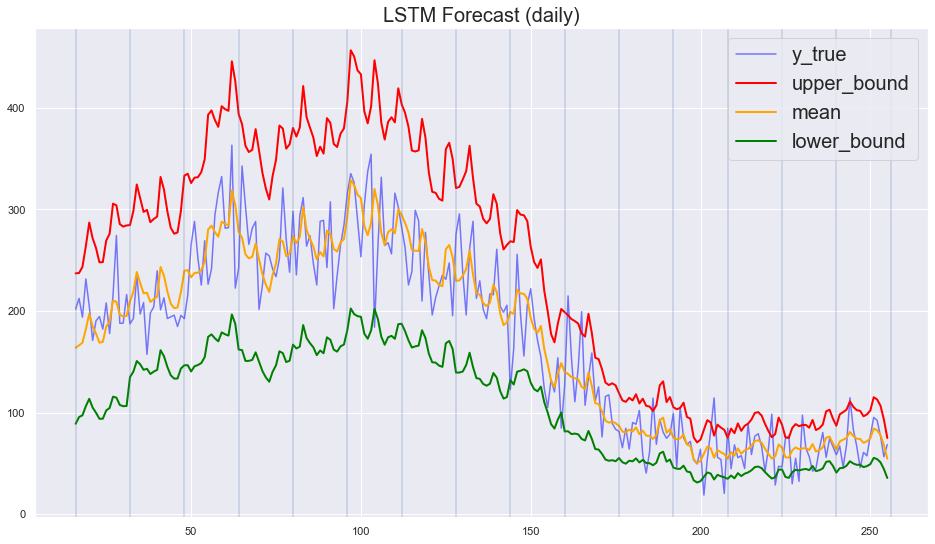

In [97]:
plt.figure(figsize=(16, 9))
plt.plot(y_true, alpha=0.5, c='blue', label='y_true')
plt.plot(y_upper_bound, linewidth=2, c='red', label='upper_bound')
plt.plot(y_pred_mean,   linewidth=2, c='orange', label='mean')
plt.plot(y_lower_bound, linewidth=2, c='green', label='lower_bound')
#plt.plot(df_data['y'])
plt.title("LSTM Forecast ({})".format(df_test.iloc[dataset_id]['freq']), fontsize=20)
plt.legend(fontsize=20)
plt.savefig('lstm_forecast.png', 
            #transparent=True,
            bbox_inches='tight')
for i in range(16, (FORECAST_STEPS+1)*16+1, 16):
    plt.axvline(x=i, alpha=0.25)
plt.show()